In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomRotation

torch.multiprocessing.set_start_method('spawn')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

from pyquaternion import Quaternion
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from tqdm import tqdm

from src.prepocess import sample_to_rangeview, pcl_to_rangeview
from src.utils import rotation_matrix
from src.settings import DATASET_PATH, LABEL_NUMBER, RV_WIDTH, RV_HEIGHT, NUSCENES
from src.models.lasernet import LaserNet
from src.losses import LaserNetLoss

RuntimeError: context has already been set

---

## Training data 

- ___Classification___ task includes semantic segmentation. We predict class labels for each point (cell) in the Range View. If a cell in RV gets a class C, we extrapolate that all points (which fell into that cell during the transformation to RV) get the same label.
- ___Regression___ task includes BB regression and mixture parameter tuning

so a single training example consists of: 

- __$X$__: range_view image | __5 x W x H__


- __$Y_{image}$:__ | __C x W x H__, where C - number of classes


- __$Y_{bb}$:__ $\{\{b_{m,1}, b_{m,2}, b_{m,3}, b_{m,4}\}, ..., \}_m^M$ | __M x 4 x 2 x W x H__ | where M is the number of bounding boxes in the image, $b_{m, j} \in R ^2$ is the absolute coordinate of $m$-th bounding box's $j$-th corner

- __$Y_{logstd}$:__ $\log(\sigma)$ of the predicted bb coordinates| __scalar__
    

### DataSets, DataLoaders and Transforms

In [2]:
from nuscenes import NuScenes
from os.path import join

class NuscenesDataset(Dataset):

    def __init__(self, data_root, n: tuple=None):
        """
        Args:
            root_dir (string): root NuScenes directory
            transform (callable, optional): Optional transform to be applied on a sample.
            
            n - tuple with left and right index boundaries, in case we don't want to use all data
        """
        assert len(n) == 2
        self.data_root = data_root
        self.nuscenes = NUSCENES

        if n:
            self.samples = self.nuscenes.sample[n[0]:n[1]]
        else:
            self.samples = self.nuscenes.sample
            
        # point_clouds_features will be of shape (N, M, 5), 
        # where N - number of samples, M - number of points in according sample's pointcloud
        self.point_clouds_features = []
        self.point_clouds_labels = []
        
        self.__set_point_clouds()
            
    def __set_point_clouds(self):

        for sample in self.samples:
            
            sample_data_token = sample['data']['LIDAR_TOP']

            my_sample_lidar_data = self.nuscenes.get('sample_data', sample_data_token)

            lidarseg_labels_filename = join(self.data_root,
                                            self.nuscenes.get('lidarseg', sample_data_token)['filename'])

            # loading directly from files to perceive the ring_index information
            points_raw = np.fromfile(self.data_root + my_sample_lidar_data["filename"], dtype=np.float32).reshape((-1, 5))
            point_labels = np.fromfile(lidarseg_labels_filename, dtype=np.uint8)
            
            self.point_clouds_features.append(points_raw)
            self.point_clouds_labels.append(point_labels)
            
        self.point_clouds_features = np.array(self.point_clouds_features)
        self.point_clouds_labels = np.array(self.point_clouds_labels)

    def __len__(self):
        return len(self.samples)

    def get_front_bb(self, sample: dict):
        """
        Function computes and returns
        An array of points points of a bounding box in sensor coordinates.
        Each point is a (x, y) coordinate, each BB is 4 points

        :param sample: nuscenes sample dictionary
        :return: np.array of shape (N, 8, 3)
        """
        my_sample_lidar_data = self.nuscenes.get('sample_data', sample['data']['LIDAR_TOP'])
        sample_annotation = self.nuscenes.get_boxes(my_sample_lidar_data['token'])

        ego_record = self.nuscenes.get('ego_pose', my_sample_lidar_data['ego_pose_token'])
        cs_record = self.nuscenes.get('calibrated_sensor', my_sample_lidar_data['calibrated_sensor_token'])

        # first step: transform from absolute to ego
        ego_translation = -np.array(ego_record['translation'])

        # second step: transform from ego to sensor
        cs_translation = -np.array(cs_record['translation'])

        corners = []
        for box in sample_annotation:
            box.translate(ego_translation)
            box.rotate(Quaternion(ego_record['rotation']).inverse)

            box.translate(cs_translation)
            box.rotate(Quaternion(cs_record['rotation']).inverse)

            # at this point bounding boxes are in sensor coordinate system
            # now we want to exclude such BB that do not have their center
            # lying in the front 90 degrees

            if box.center[1] <= 0:
                continue

            box.center_azimuth = np.degrees(np.arctan(box.center[0] / box.center[1]))

            # Transform front azimuth to be in range from 0 to 180
            box.center_azimuth = 90 - box.center_azimuth
            if not (45 < box.center_azimuth < 135):
                continue

            corners.append(box.bottom_corners())
        
        if len(corners) > 0:
            return np.transpose(np.array(corners), (0, 2, 1))
        else:
            return np.zeros((1, 4, 3))
    
    def points_in_box(self, coordinates, bounding_box_corners):
        """
            bounding_box_corners: bbc of a single bb
            return a mask of whether points that are in the box
        """
        coords_x = coordinates[0]
        coords_y = coordinates[1]
        
        min_bb_x = bounding_box_corners[:, 0].min()
        max_bb_x = bounding_box_corners[:, 0].max()
        min_bb_y = bounding_box_corners[:, 1].min()
        max_bb_y = bounding_box_corners[:, 1].max()

        c1 = min_bb_x <= coords_x  # left_top/left_bottom.x <= coordinate.x
        c2 = max_bb_x >= coords_x  # right_bottom/right_top.x >= coordinate.x
        c3 = min_bb_y <= coords_y  # left/right_bottom.y <= coordinate.y
        c4 = max_bb_y >= coords_y  # right_top/left_top.y >= coordinate.y

        c = np.logical_and(np.logical_and(c1, c2),
                           np.logical_and(c3, c4))
        return c
    
    def get_bb_targets(self, idx, bounding_box_corners):
        coordinates = self.point_clouds_features[idx][:2] 
    
        for bb_c in bounding_box_corners:

            if self.points_in_box(coordinates, bb_c).any():
                return np.array(bb_c[:, :2])
            
            else:
                return np.zeros_like(bb_c[:, :2])
    
    def __getitem__(self, idx, compute_boxes=True):
        """
        compute_box will be set to False in child classes, so target boxes are computed after rotations
        
        """
        
        sample_idx = self.samples[idx]
        pcl_features = self.point_clouds_features[idx]
        pcl_labels = self.point_clouds_labels[idx]
        
        if compute_boxes:
            front_bbs = self.get_front_bb(sample_idx)
            target_bounding_boxes = self.get_bb_targets(idx, front_bbs)
    
            return pcl_features, pcl_labels, target_bounding_boxes
        
        else:
            return pcl_features, pcl_labels, []

In [3]:
class NuscenesRangeViewDataset(NuscenesDataset):

    def __init__(self, data_root, n=None):
        super().__init__(data_root, n)
        
            
    def __len__(self):
        return len(self.samples)
    
    def get_bb_targets(self, range_view_coordinates, bounding_box_corners):
        bbc_target = np.zeros((4, 2, RV_WIDTH, RV_HEIGHT))
                
        for bbc in bounding_box_corners:
            point_mask = self.points_in_box(range_view_coordinates, bbc)
            bbc_target[:, :, point_mask] = np.expand_dims(bbc, 2)
            
        return bbc_target.reshape((8, RV_WIDTH, RV_HEIGHT))
        
        
    def __getitem__(self, idx):
        pcl_features, pcl_targets, _ = super().__getitem__(idx, compute_boxes=False)
        
        rotate_prob = np.random.uniform()
        
#         if rotate_prob > 0.5:
#             rotation_angle_y = np.random.uniform(10, 90)

#             rotation = RandomRotation((0, rotation_angle_y))
#             print("0", pcl_features[:, :2].shape)
#             pcl_features[:, :2] = pcl_features[:, :2] @ rotation_matrix(torch.Tensor([rotation_angle_y])).cpu().numpy()
#             print("1", pcl_features[:, :2].shape)
            
        range_view, targets = pcl_to_rangeview(pcl_features, pcl_targets)
        
        range_view = range_view.transpose(2, 1, 0)
        targets = targets.transpose(2, 1, 0)
        
        front_bbs = self.get_front_bb(self.samples[idx])[:, :, :2]  # N x 4 x 2 since we only need xy
        target_bounding_boxes = self.get_bb_targets(range_view[:2], front_bbs)
    
        return torch.Tensor(range_view.copy()), torch.Tensor(targets.copy()), torch.Tensor(target_bounding_boxes.copy())

In [4]:
%%time
train_dataset = NuscenesRangeViewDataset(data_root=DATASET_PATH, n=(0, 4000))
val_dataset = NuscenesRangeViewDataset(data_root=DATASET_PATH, n=(4000, 5000))

<ipython-input-2-79e4882f6273>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.point_clouds_features = np.array(self.point_clouds_features)
<ipython-input-2-79e4882f6273>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.point_clouds_labels = np.array(self.point_clouds_labels)


CPU times: user 111 ms, sys: 1.22 s, total: 1.33 s
Wall time: 1.33 s


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers=0)

---

## Training the model

1. For each point in the image, we use the focal loss $L_{prob}$ to learn the class probabilities $\{p_c\}_{c=1}^C$. The classification loss for the entire image is defined as follows 
$$
L_{cls} = {1 \over P} \sum_i{L_{prob, i}}
$$ 
where P is the number of points in the image

2. For each point on an object, we learn the parameters of the object’s mixture model by first identifying which component best matches the ground truth
$$
k^* = \arg \min_k || \hat b_k − b^{gt} ||
$$
where $\hat b_k$ is the k-th mean component of the mixture model
and $b^{gt}$ is the corresponding ground truth bounding box.

3. Afterwards, we update the parameters of the $k^{*}$ component
$$
L_{box} = \sum_n {1 \over \hat \sigma_{k^*}} | \hat b_{n, k} − b^{gt}_n | + \log{\hat \sigma_{k^*}}
$$


4. Next, we update the mixture weights $\{α_k\}^K_{k=1}$ again using the multi-class cross entropy loss $L_{mix}$, where the positive label corresponds to the $k^*$ component

5. The regression loss for the entire image is defined as follows:
$$
L_{reg} = {{1 \over N} \sum_i{L_{box, i} + \lambda L_{mix, i} \over n_i}}
$$
where $L_{box, i}$ and $L_{mix, i}$ are the losses for the $i$-th point in the image which is on an object, $n_i$ is the total number of points that lie on the same object as $i$, $N$ is the total instances of objects in the image, and $\lambda$ is the relative weighting of the two losses.

6. Final loss is 

$$
L = L_{reg} + L_{cls}
$$

___!NOTE! In this experiment we do not model a distribution of BB, which is equivalent to having a single mixture component or  K=1. Meaning: we do not have $L_{mix}$, we skip step 2___

---

In [8]:
EPOCHS = 2000

lasernet = torch.nn.DataParallel(LaserNet(), device_ids=[0, 1])
loss = LaserNetLoss(focal_loss_reduction='mean')
optimizer = torch.optim.Adam(lasernet.parameters(), lr=0.000001)

lasernet.zero_grad()
loss.zero_grad()
optimizer.zero_grad()

train_losses = []
train_accs = []

val_losses = []
val_accs = []
for epoch in tqdm(range(EPOCHS)):
    for batch_rv, batch_labels, batch_target_bbs in tqdm(train_dataloader):
        
        batch_pointclass_preds, batch_bb_param_preds, batch_log_std_preds = lasernet(x=batch_rv)
        
        batch_logstd = torch.log(torch.std(batch_bb_param_preds, axis=(1, 2, 3)))        
        
        L_train = loss(batch_pointclass_preds, batch_bb_param_preds, batch_log_std_preds,
                 batch_labels,           batch_target_bbs)
        
        train_losses.append(L_train.item())
        
        lasernet.zero_grad()
        L_train.backward()
        optimizer.step()
        
    
    with torch.no_grad():
        for batch_rv, batch_labels, batch_target_bbs in val_dataloader:
            batch_pointclass_preds, batch_bb_param_preds, batch_log_std_preds = lasernet(x=batch_rv)
            
            L_val = loss(batch_pointclass_preds, batch_bb_param_preds, batch_log_std_preds,
                         batch_labels,           batch_target_bbs)
        
            val_losses.append(L_val.item())
            
    if epoch % 7 == 0:
        torch.save(lasernet, f'lasernet-d2k-b64-e{epoch}-adam-lre6')
        print(epoch, "train_loss", L_train.item(), "val_loss", L_val.item())
        

  0%|          | 0/2000 [09:55<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [7, 128, 32] at entry 0 and [32, 128, 32] at entry 10

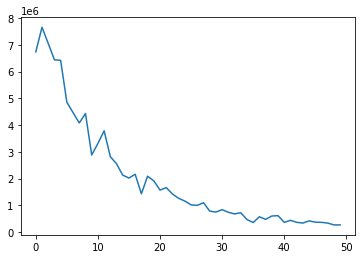

In [14]:
plt.plot(train_losses)

In [16]:
val_losses

[]

In [ ]:
#         rv_example = batch_rv[7]
#         bb_corners_targets_example = batch_target_bbs[7]
        
#         _, bb_w, bb_h = np.nonzero(bb_corners_targets_example).T
#         bb_w, bb_h = np.unique(bb_w.cpu()), np.unique(bb_h.cpu())
#         fig = go.Figure(data=[go.Scatter3d(x=rv_example[0].cpu().flatten(),
#                                            y=rv_example[1].cpu().flatten(),
#                                            z=np.zeros_like(rv_example[2].cpu().flatten()),
#                                            mode='markers',
#                                            marker=dict(size=2))])

#         for wi in np.unique(bb_w):
#             for he in np.unique(bb_h):
#                 x = bb_corners_targets_example[::2, wi, he]
#                 y = bb_corners_targets_example[1::2, wi, he]

#                 fig.add_mesh3d(x=x.cpu(), 
#                                y=y.cpu(),
#                                z=np.zeros_like(x.cpu()))

#         fig.show()